# MCMC Analysis of Eclipse Impact Parameter

This notebook performs MCMC analysis on the eclipse impact parameter $b_{\text{occ}}$ as defined in Winn (2010):

$$b_{\text{occ}} = \frac{a \cos i}{R_\star} \left(\frac{1 - e^2}{1 - e \sin \omega}\right)$$

which can be rewritten as:

$$b_{\text{occ}} = \frac{a}{R_\star} \cos i \left(\frac{1 - e^2}{1 - e \sin \omega}\right)$$

where:
- $a/R_\star$ = scaled semi-major axis (sampled as single parameter)
- $i$ = orbital inclination
- $e$ = eccentricity
- $\omega$ = argument of periastron

**Note:** We sample on $a/R_\star$ directly rather than separately on $a$ and $R_\star$, as this parameter is often better constrained observationally from transit light curves.

This analysis uses the updated MCS and TPC data files (2025-07-18).

In [14]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import emcee
import corner
from astropy import units as u
from astropy.constants import R_sun
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

## 1. Load Data

In [15]:
# Load the updated data files
mcs_file = '../../data/raw/Ariel_MCS_Known_2025-07-18.csv'
tpc_file = '../../data/raw/Ariel_MCS_TPCs_2025-07-18.csv'

mcs_df = pd.read_csv(mcs_file)
tpc_df = pd.read_csv(tpc_file)

print(f"MCS Known Planets: {len(mcs_df)}")
print(f"TPC Candidates: {len(tpc_df)}")
print(f"\nTotal systems to analyze: {len(mcs_df) + len(tpc_df)}")

MCS Known Planets: 808
TPC Candidates: 2046

Total systems to analyze: 2854


## 2. Identify Required Columns and Extract Parameters

In [16]:
# Define the columns needed for the eclipse impact parameter calculation
# Column names differ between MCS and TPC files

# For MCS (Known Planets)
mcs_columns = {
    'name': 'Planet Name',
    'a_over_rs': 'a/Rs',
    'a_over_rs_err_lower': 'a/Rs Error Lower',
    'a_over_rs_err_upper': 'a/Rs Error Upper',
    'inclination': 'Inclination',
    'inclination_err_lower': 'Inclination Error Lower',
    'inclination_err_upper': 'Inclination Error Upper',
    'impact_parameter': 'Impact Parameter',
    'impact_parameter_err_lower': 'Impact Parameter Error Lower',
    'impact_parameter_err_upper': 'Impact Parameter Error Upper',
    'eccentricity': 'Eccentricity',
    'eccentricity_err_lower': 'Eccentricity Error Lower',
    'eccentricity_err_upper': 'Eccentricity Error Upper',
    'periastron': 'Periastron',
    'periastron_err_lower': 'Periastron Error Lower',
    'periastron_err_upper': 'Periastron Error Upper',
    'rp_rs': 'Rp/Rs',
    'rp_rs_err_lower': 'Rp/Rs Error Lower',
    'rp_rs_err_upper': 'Rp/Rs Error Upper',
    'eclipse_flag': 'Eclipse Flag'
}

# For TPC (Candidates)
tpc_columns = {
    'name': 'Planet Name',
    'a_over_rs': 'a/Rs',
    'inclination': 'Inclination',
    'impact_parameter': 'Impact Parameter',
    'eccentricity': 'Eccentricity',
    'periastron': 'Periastron',
    'rp_rs': 'Rp/Rs'
}

print("MCS Columns:")
for key, col in mcs_columns.items():
    if col in mcs_df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - NOT FOUND")

print("\nTPC Columns:")
for key, col in tpc_columns.items():
    if col in tpc_df.columns:
        print(f"  ✓ {col}")
    else:
        print(f"  ✗ {col} - NOT FOUND")

MCS Columns:
  ✓ Planet Name
  ✓ a/Rs
  ✓ a/Rs Error Lower
  ✓ a/Rs Error Upper
  ✓ Inclination
  ✓ Inclination Error Lower
  ✓ Inclination Error Upper
  ✓ Impact Parameter
  ✓ Impact Parameter Error Lower
  ✓ Impact Parameter Error Upper
  ✓ Eccentricity
  ✓ Eccentricity Error Lower
  ✓ Eccentricity Error Upper
  ✓ Periastron
  ✓ Periastron Error Lower
  ✓ Periastron Error Upper
  ✓ Rp/Rs
  ✓ Rp/Rs Error Lower
  ✓ Rp/Rs Error Upper
  ✓ Eclipse Flag

TPC Columns:
  ✓ Planet Name
  ✓ a/Rs
  ✓ Inclination
  ✓ Impact Parameter
  ✓ Eccentricity
  ✓ Periastron
  ✓ Rp/Rs


## 3. Define the Eclipse Impact Parameter Model

In [17]:
def eclipse_impact_parameter(a_over_rs, inclination_deg, eccentricity, periastron_deg):
    """
    Calculate the eclipse impact parameter b_occ.
    
    Formula from Winn (2010):
    b_occ = (a/R*) * cos(i) * ((1 - e^2) / (1 - e * sin(omega)))
    
    Parameters:
    -----------
    a_over_rs : float
        Scaled semi-major axis (a/R*), dimensionless
    inclination_deg : float
        Orbital inclination in degrees
    eccentricity : float
        Orbital eccentricity
    periastron_deg : float
        Argument of periastron in degrees
    
    Returns:
    --------
    b_occ : float
        Eclipse impact parameter (dimensionless)
    """
    # Convert to radians
    i_rad = np.radians(inclination_deg)
    omega_rad = np.radians(periastron_deg)
    
    # Eccentricity correction factor
    ecc_factor = (1 - eccentricity**2) / (1 - eccentricity * np.sin(omega_rad))
    
    # Calculate the eclipse impact parameter
    b_occ = a_over_rs * np.cos(i_rad) * ecc_factor
    
    return b_occ

def transit_impact_to_inclination(b_tra, a_over_rs):
    """
    Convert transit impact parameter to inclination.
    
    Parameters:
    -----------
    b_tra : float
        Transit impact parameter
    a_over_rs : float
        Scaled semi-major axis (a/R*)
    
    Returns:
    --------
    i_deg : float
        Inclination in degrees
    """
    # Clip b_tra to avoid numerical issues
    b_clipped = np.clip(b_tra, -1.5, 1.5)
    cos_i = b_clipped / a_over_rs
    # Ensure cos_i is in valid range
    cos_i = np.clip(cos_i, -1.0, 1.0)
    i_rad = np.arccos(cos_i)
    i_deg = np.degrees(i_rad)
    return i_deg

# Test the function with sample values
test_b_occ = eclipse_impact_parameter(
    a_over_rs=10.0,
    inclination_deg=89.0,
    eccentricity=0.0,
    periastron_deg=90.0
)
print(f"Test b_occ calculation: {test_b_occ:.4f}")

# Test inclination conversion
test_i = transit_impact_to_inclination(b_tra=0.3, a_over_rs=10.0)
print(f"Test inclination from b_tra: {test_i:.2f} degrees")

Test b_occ calculation: 0.1745
Test inclination from b_tra: 88.28 degrees


## 4. Prepare Data for MCMC

Extract systems with complete parameter information for MCMC analysis.

In [18]:
def prepare_system_data(df, is_mcs=True):
    """
    Prepare system data for MCMC analysis.
    
    Parameters:
    -----------
    df : DataFrame
        Input dataframe (MCS or TPC)
    is_mcs : bool
        Whether the dataframe is MCS (True) or TPC (False)
    
    Returns:
    --------
    systems : list of dict
        List of systems with required parameters and uncertainties
    """
    systems = []
    
    for idx, row in df.iterrows():
        # Extract parameters based on dataset type
        if is_mcs:
            name = row.get('Planet Name', f'MCS_{idx}')
            a_over_rs = row.get('a/Rs')
            a_over_rs_err_lower = abs(row.get('a/Rs Error Lower', 0))
            a_over_rs_err_upper = abs(row.get('a/Rs Error Upper', 0))
            b_tra = row.get('Impact Parameter')  # Transit impact parameter
            b_tra_err_lower = abs(row.get('Impact Parameter Error Lower', 0))
            b_tra_err_upper = abs(row.get('Impact Parameter Error Upper', 0))
            inclination = row.get('Inclination')
            inclination_err_lower = abs(row.get('Inclination Error Lower', 0))
            inclination_err_upper = abs(row.get('Inclination Error Upper', 0))
            eccentricity = row.get('Eccentricity', 0.0)
            eccentricity_err_lower = abs(row.get('Eccentricity Error Lower', 0))
            eccentricity_err_upper = abs(row.get('Eccentricity Error Upper', 0))
            periastron = row.get('Periastron', 90.0)
            periastron_err_lower = abs(row.get('Periastron Error Lower', 0))
            periastron_err_upper = abs(row.get('Periastron Error Upper', 0))
            rp_rs = row.get('Rp/Rs')
            rp_rs_err_lower = abs(row.get('Rp/Rs Error Lower', 0))
            rp_rs_err_upper = abs(row.get('Rp/Rs Error Upper', 0))
            eclipse_flag = row.get('Eclipse Flag', False)
            # Convert string 'TRUE'/'FALSE' to boolean
            if isinstance(eclipse_flag, str):
                eclipse_flag = eclipse_flag.upper() == 'TRUE'
        else:  # TPC
            name = row.get('Planet Name', f'TPC_{idx}')
            a_over_rs = row.get('a/Rs')
            a_over_rs_err_lower = 0.0  # Not available in TPC
            a_over_rs_err_upper = 0.0
            b_tra = row.get('Impact Parameter')
            b_tra_err_lower = 0.0
            b_tra_err_upper = 0.0
            inclination = row.get('Inclination')
            inclination_err_lower = 0.0  # Not available in TPC
            inclination_err_upper = 0.0
            eccentricity = row.get('Eccentricity', 0.0)
            eccentricity_err_lower = 0.0
            eccentricity_err_upper = 0.0
            periastron = row.get('Periastron', 90.0)
            periastron_err_lower = 0.0
            periastron_err_upper = 0.0
            rp_rs = row.get('Rp/Rs')
            rp_rs_err_lower = 0.0
            rp_rs_err_upper = 0.0
            eclipse_flag = None  # Not available in TPC
        
        # Check if all required parameters are available and valid
        if all([pd.notna(x) for x in [a_over_rs, inclination]]):
            # Handle NaN values with defaults
            if pd.isna(eccentricity):
                eccentricity = 0.0
            if pd.isna(periastron):
                periastron = 90.0
            if pd.isna(b_tra):
                # Derive from inclination and a/Rs if not available
                b_tra = a_over_rs * np.cos(np.radians(inclination))
            if pd.isna(rp_rs):
                rp_rs = 0.1  # Default placeholder
            
            # Average uncertainties or use defaults
            a_over_rs_err = (a_over_rs_err_lower + a_over_rs_err_upper) / 2 if (a_over_rs_err_lower + a_over_rs_err_upper) > 0 else a_over_rs * 0.05
            b_tra_err = (b_tra_err_lower + b_tra_err_upper) / 2 if (b_tra_err_lower + b_tra_err_upper) > 0 else 0.05
            inclination_err = (inclination_err_lower + inclination_err_upper) / 2 if (inclination_err_lower + inclination_err_upper) > 0 else 0.5
            eccentricity_err = (eccentricity_err_lower + eccentricity_err_upper) / 2 if (eccentricity_err_lower + eccentricity_err_upper) > 0 else 0.01
            periastron_err = (periastron_err_lower + periastron_err_upper) / 2 if (periastron_err_lower + periastron_err_upper) > 0 else 10.0
            rp_rs_err = (rp_rs_err_lower + rp_rs_err_upper) / 2 if (rp_rs_err_lower + rp_rs_err_upper) > 0 else rp_rs * 0.05
            
            # Compute cos(i) and its uncertainty for direct sampling
            cos_i = np.cos(np.radians(inclination))
            # Propagate inclination uncertainty to cos(i) using: d(cos i)/di = -sin(i)
            cos_i_err = abs(np.sin(np.radians(inclination)) * np.radians(inclination_err))
            if cos_i_err == 0:
                cos_i_err = 0.01  # Default minimum uncertainty
            
            systems.append({
                'name': name,
                'a_over_rs': a_over_rs,
                'a_over_rs_err': a_over_rs_err,
                'b_tra': b_tra,
                'b_tra_err': b_tra_err,
                'inclination': inclination,
                'inclination_err': inclination_err,
                'cos_i': cos_i,
                'cos_i_err': cos_i_err,
                'eccentricity': eccentricity,
                'eccentricity_err': eccentricity_err,
                'periastron': periastron,
                'periastron_err': periastron_err,
                'rp_rs': rp_rs,
                'eclipse_flag': eclipse_flag,
                'dataset': 'MCS' if is_mcs else 'TPC'
            })
    
    return systems

# Prepare data from both datasets
mcs_systems = prepare_system_data(mcs_df, is_mcs=True)
tpc_systems = prepare_system_data(tpc_df, is_mcs=False)

all_systems = mcs_systems + tpc_systems

print(f"Systems prepared for MCMC:")
print(f"  MCS: {len(mcs_systems)}")
print(f"  TPC: {len(tpc_systems)}")
print(f"  Total: {len(all_systems)}")

# Display first few systems
if len(all_systems) > 0:
    print(f"\nExample system: {all_systems[0]['name']}")
    for key, val in all_systems[0].items():
        if key != 'name':
            print(f"  {key}: {val}")

Systems prepared for MCMC:
  MCS: 808
  TPC: 2046
  Total: 2854

Example system: K2-232b
  a_over_rs: 17.28
  a_over_rs_err: 0.54
  b_tra: 0.108
  b_tra_err: 0.076
  inclination: 89.61
  inclination_err: 0.275
  cos_i: 0.006806731520561874
  cos_i_err: 0.004799544253852854
  eccentricity: 0.255
  eccentricity_err: 0.035
  periastron: 170.9
  periastron_err: 172.85
  rp_rs: 0.08811
  eclipse_flag: False
  dataset: MCS


## 5. MCMC Setup

Define the log-likelihood and log-prior functions for the MCMC analysis.

In [19]:
# Import required for priors
from scipy.stats import beta as beta_dist
from scipy.stats import norm

# ---------------------------------------------------------------------
# Eccentricity prior (Kipping-style Beta prior)
# ---------------------------------------------------------------------

def beta_prior_ecc(e, alpha=0.867, beta=3.03):
    """
    Kipping-style Beta prior for eccentricity (suitable for short-period planets).
    Returns log probability.
    
    Parameters
    ----------
    e : float
        Eccentricity value.
    alpha, beta : float
        Beta distribution parameters (Kipping 2013/2014 defaults).
    
    Returns
    -------
    log_prob : float
        Log probability.
    """
    if e < 0.0 or e >= 1.0:
        return -np.inf
    lp = beta_dist.logpdf(e, alpha, beta)
    if not np.isfinite(lp):
        return -np.inf
    return lp


# ---------------------------------------------------------------------
# Priors: theta = [a_over_rs, cos_i, e, omega_deg]
# system = dict with transit-based constraints
#   system['a_over_rs'], system['a_over_rs_err']
#   system['cos_i'], system['cos_i_err']
#   system['rp_rs']
# ---------------------------------------------------------------------

def log_prior(theta, system):
    """
    Log prior probability with informative priors based on transit observations.
    
    Parameters
    ----------
    theta : array-like
        [a_over_rs, cos_i, e, omega_deg]
    system : dict
        System parameters and uncertainties from transit fits.
    
    Returns
    -------
    log_prob : float
        Log prior probability.
    """
    a_over_rs, cos_i, e, omega_deg = theta
    
    # Physical bounds
    if a_over_rs <= 0.0:
        return -np.inf
    if e < 0.0 or e >= 1.0:
        return -np.inf
    if omega_deg < 0.0 or omega_deg >= 360.0:
        return -np.inf
    if cos_i < -1.0 or cos_i > 1.0:
        return -np.inf
    
    log_prob = 0.0
    
    # Gaussian prior on a/Rs (from transit + stellar modeling)
    log_prob += norm.logpdf(
        a_over_rs,
        loc=system['a_over_rs'],
        scale=system['a_over_rs_err']
    )
    
    # Gaussian prior on cos(i) (derived once from transit solution)
    log_prob += norm.logpdf(
        cos_i,
        loc=system['cos_i'],
        scale=system['cos_i_err']
    )
    
    # Kipping-style Beta prior on eccentricity (favors low e for short-period planets)
    log_prob += beta_prior_ecc(e, alpha=0.867, beta=3.03)
    
    # Uniform prior on omega in [0, 360): normalization is constant, can be skipped
    return log_prob


# ---------------------------------------------------------------------
# Geometry-only "likelihood": enforce occultation existence
# ---------------------------------------------------------------------

def log_likelihood(theta, system):
    """
    Log 'likelihood' function.
    
    For pure detectability / geometry sampling, we impose only a hard constraint
    that an occultation must exist:
    
        |b_occ| <= 1 + k   (where k = Rp/Rs)
    
    If the condition is satisfied, we return 0 (flat likelihood); otherwise -inf.
    """
    a_over_rs, cos_i, e, omega_deg = theta
    
    # Inclination in degrees from cos(i)
    cos_i_clipped = np.clip(cos_i, -1.0, 1.0)
    i_deg = np.degrees(np.arccos(cos_i_clipped))
    
    # Occultation impact parameter (Winn 2010; superior conjunction)
    # eclipse_impact_parameter(a_over_rs, i_deg, e, omega_deg) implements:
    #   b_occ = (a/Rs * cos i) * (1 - e^2) / (1 - e * sin(omega))
    b_occ = eclipse_impact_parameter(a_over_rs, i_deg, e, omega_deg)
    
    # Hard constraint: occultation must exist (grazing or deeper)
    k = system['rp_rs']  # Rp/Rs from transit
    if np.abs(b_occ) > (1.0 + k):
        return -np.inf
    
    # Geometry-only likelihood: flat if occultation exists
    return 0.0


# ---------------------------------------------------------------------
# Posterior
# ---------------------------------------------------------------------

def log_probability(theta, system):
    """
    Log posterior probability: prior + likelihood.
    """
    lp = log_prior(theta, system)
    if not np.isfinite(lp):
        return -np.inf
    ll = log_likelihood(theta, system)
    if not np.isfinite(ll):
        return -np.inf
    return lp + ll


print("MCMC geometry / prior functions defined successfully.")

MCMC geometry / prior functions defined successfully.


## 6. Run MCMC for Selected Systems

Run MCMC to propagate uncertainties through the eclipse impact parameter calculation.

In [20]:
def run_mcmc_for_system(system, nwalkers=32, nsteps=5000, burn_in=1000):
    """
    Run MCMC for a single system with informative priors.
    
    Parameters:
    -----------
    system : dict
        System parameters
    nwalkers : int
        Number of MCMC walkers
    nsteps : int
        Number of MCMC steps
    burn_in : int
        Number of burn-in steps to discard
    
    Returns:
    --------
    results : dict
        MCMC results including samples and b_occ distribution
    """
    # Number of parameters: a/Rs, cos(i), e, omega
    ndim = 4
    
    # Initial positions for walkers
    p0 = np.array([
        system['a_over_rs'],
        system['cos_i'],
        system['eccentricity'],
        system['periastron']
    ])
    
    # Add random offsets with guaranteed minimum spread to avoid linear dependence
    perturbation_scale = np.array([
        max(system['a_over_rs_err'] * 0.1, system['a_over_rs'] * 0.01),  # At least 1% of a/Rs
        max(system['cos_i_err'] * 0.1, 0.01),  # At least 0.01 in cos(i)
        max(system['eccentricity_err'] * 0.1, 0.05),  # At least 0.05 in e
        max(system['periastron_err'] * 0.1, 10.0)  # At least 10 degrees in omega
    ])
    
    pos = p0 + np.random.randn(nwalkers, ndim) * perturbation_scale
    
    # Ensure all walkers start in valid parameter space
    # Clip a/Rs to positive values with reasonable bounds
    pos[:, 0] = np.clip(pos[:, 0], p0[0] * 0.8, p0[0] * 1.2)
    # Clip cos(i) to valid range
    pos[:, 1] = np.clip(pos[:, 1], -1.0, 1.0)
    # Clip eccentricity to [0, 1)
    pos[:, 2] = np.clip(pos[:, 2], 0.0, 0.99)
    # Wrap omega to [0, 360)
    pos[:, 3] = pos[:, 3] % 360.0
    
    # Initialize sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(system,))
    
    # Run MCMC
    print(f"Running MCMC for {system['name']}...")
    sampler.run_mcmc(pos, nsteps, progress=True)
    
    # Get samples after burn-in
    samples = sampler.get_chain(discard=burn_in, flat=True)
    
    # Calculate derived quantities for each sample
    b_occ_samples = []
    i_deg_samples = []
    
    for s in samples:
        a_over_rs, cos_i, e, omega = s
        # Derive inclination from cos(i)
        cos_i_clipped = np.clip(cos_i, -1.0, 1.0)
        i_deg = np.degrees(np.arccos(cos_i_clipped))
        i_deg_samples.append(i_deg)
        
        # Calculate b_occ
        b_occ = eclipse_impact_parameter(a_over_rs, i_deg, e, omega)
        b_occ_samples.append(b_occ)
    
    b_occ_samples = np.array(b_occ_samples)
    i_deg_samples = np.array(i_deg_samples)
    
    # Calculate statistics
    b_occ_median = np.median(b_occ_samples)
    b_occ_std = np.std(b_occ_samples)
    b_occ_16, b_occ_84 = np.percentile(b_occ_samples, [16, 84])
    
    i_median = np.median(i_deg_samples)
    i_16, i_84 = np.percentile(i_deg_samples, [16, 84])
    
    # Calculate tier based on b_occ_84 and system's k = Rp/Rs
    k = system['rp_rs']
    if b_occ_84 < 1.0:
        tier = 1  # Premium: non-grazing even at +1σ
        tier_label = "Premium (non-grazing)"
    elif b_occ_84 < 1.0 + k:
        tier = 2  # Good: eclipse certain, may be grazing
        tier_label = "Good (includes grazing)"
    elif b_occ_median < 1.0 + k:
        tier = 3  # Possible: eclipse likely but uncertain
        tier_label = "Possible (uncertain)"
    else:
        tier = 4  # Risky: eclipse unlikely
        tier_label = "Risky (eclipse unlikely)"
    
    results = {
        'name': system['name'],
        'dataset': system['dataset'],
        'eclipse_flag': system['eclipse_flag'],
        'samples': samples,
        'b_occ_samples': b_occ_samples,
        'i_deg_samples': i_deg_samples,
        'b_occ_median': b_occ_median,
        'b_occ_std': b_occ_std,
        'b_occ_16': b_occ_16,
        'b_occ_84': b_occ_84,
        'b_occ_err_lower': b_occ_median - b_occ_16,
        'b_occ_err_upper': b_occ_84 - b_occ_median,
        'i_median': i_median,
        'i_err_lower': i_median - i_16,
        'i_err_upper': i_84 - i_median,
        'k': k,
        'tier': tier,
        'tier_label': tier_label,
        'acceptance_fraction': np.mean(sampler.acceptance_fraction)
    }
    print(f"  Eclipse observed: {system['eclipse_flag']}")
    print(f"  b_occ = {b_occ_median:.4f} +{b_occ_84 - b_occ_median:.4f} -{b_occ_median - b_occ_16:.4f}")
    print(f"  i = {i_median:.2f} +{i_84 - i_median:.2f} -{i_median - i_16:.2f} degrees")
    print(f"  k (Rp/Rs) = {k:.4f}, 1+k = {1+k:.4f}")
    print(f"  Tier: {tier} - {tier_label}")
    print(f"  Acceptance fraction: {results['acceptance_fraction']:.3f}")
    
    return results

print("MCMC runner function defined.")

MCMC runner function defined.


## 7. Analyze First Few Systems (Example)

Run MCMC on the first few systems to demonstrate the analysis.

In [21]:
# Find systems with observed eclipses and run MCMC on them
systems_with_eclipse = [s for s in all_systems if s['eclipse_flag'] == True]
systems_without_eclipse = [s for s in all_systems if s['eclipse_flag'] == False]

print(f"Systems with observed eclipses: {len(systems_with_eclipse)}")
print(f"Systems without observed eclipses: {len(systems_without_eclipse)}")
print(f"Systems with unknown eclipse status (TPC): {len([s for s in all_systems if s['eclipse_flag'] is None])}")

# Run MCMC on first 3 systems with observed eclipses
n_examples = min(3, len(systems_with_eclipse))
mcmc_results = []

print(f"\n{'='*60}")
print(f"Running MCMC on {n_examples} systems WITH observed eclipses")
print(f"{'='*60}\n")

for i in range(n_examples):
    system = systems_with_eclipse[i]
    try:
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        mcmc_results.append(result)
    except Exception as e:
        print(f"Error processing {system['name']}: {e}")
        continue

Systems with observed eclipses: 99
Systems without observed eclipses: 709
Systems with unknown eclipse status (TPC): 2046

Running MCMC on 3 systems WITH observed eclipses

Running MCMC for KELT-20b...


100%|██████████| 3000/3000 [00:06<00:00, 446.86it/s]



  Eclipse observed: True
  b_occ = 0.4860 +0.0811 -0.1027
  i = 86.13 +0.26 -0.28 degrees
  k (Rp/Rs) = 0.1144, 1+k = 1.1144
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499
Running MCMC for WASP-46b...


100%|██████████| 3000/3000 [00:06<00:00, 429.82it/s]



  Eclipse observed: True
  b_occ = 0.7165 +0.0897 -0.1531
  i = 82.80 +0.17 -0.17 degrees
  k (Rp/Rs) = 0.1407, 1+k = 1.1407
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495
Running MCMC for WASP-17b...


100%|██████████| 3000/3000 [00:06<00:00, 466.99it/s]



  Eclipse observed: True
  b_occ = 0.3679 +0.1088 -0.1065
  i = 86.85 +0.62 -0.64 degrees
  k (Rp/Rs) = 0.1302, 1+k = 1.1302
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498


## 8. Visualize Results

Create corner plots and posterior distributions for the MCMC results.

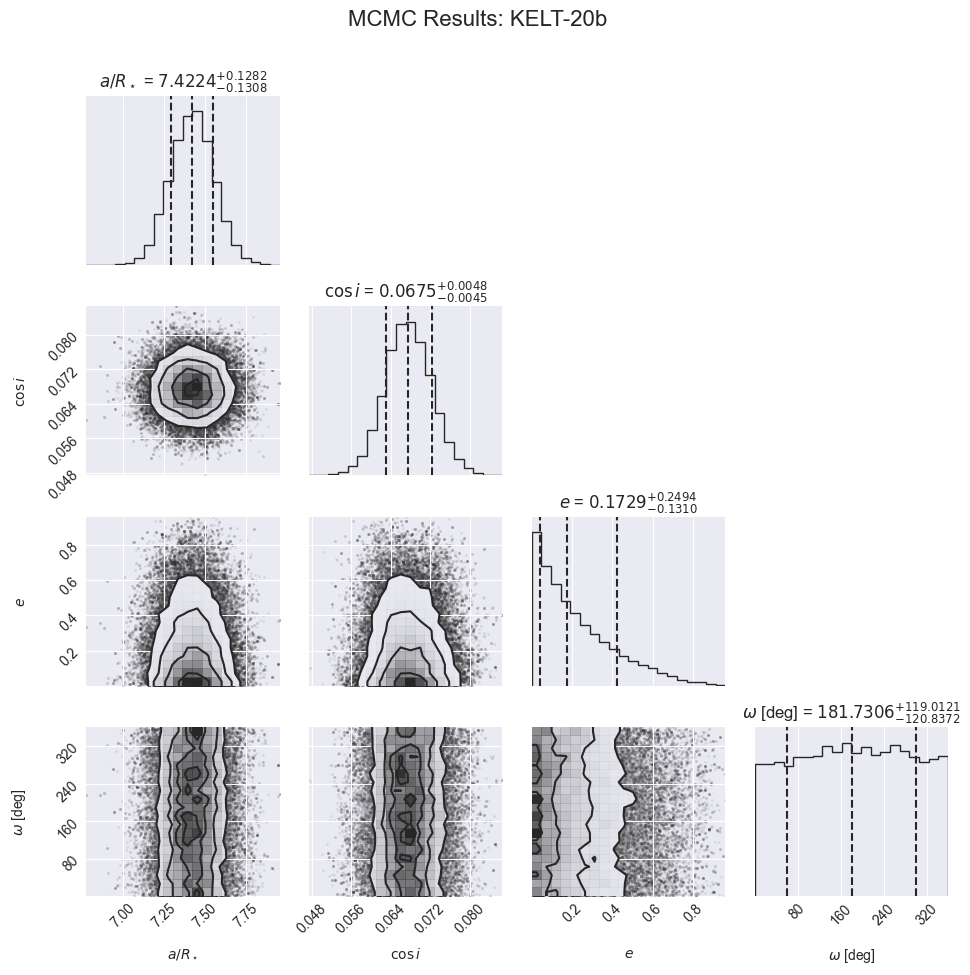

In [22]:
# Plot corner plot for the first system
if len(mcmc_results) > 0:
    result = mcmc_results[0]
    
    labels = [r'$a/R_\star$', r'$\cos i$', r'$e$', r'$\omega$ [deg]']
    
    fig = corner.corner(
        result['samples'],
        labels=labels,
        quantiles=[0.16, 0.5, 0.84],
        show_titles=True,
        title_fmt='.4f',
        title_kwargs={"fontsize": 12}
    )
    
    fig.suptitle(f"MCMC Results: {result['name']}", fontsize=16, y=1.01)
    plt.tight_layout()
    plt.show()

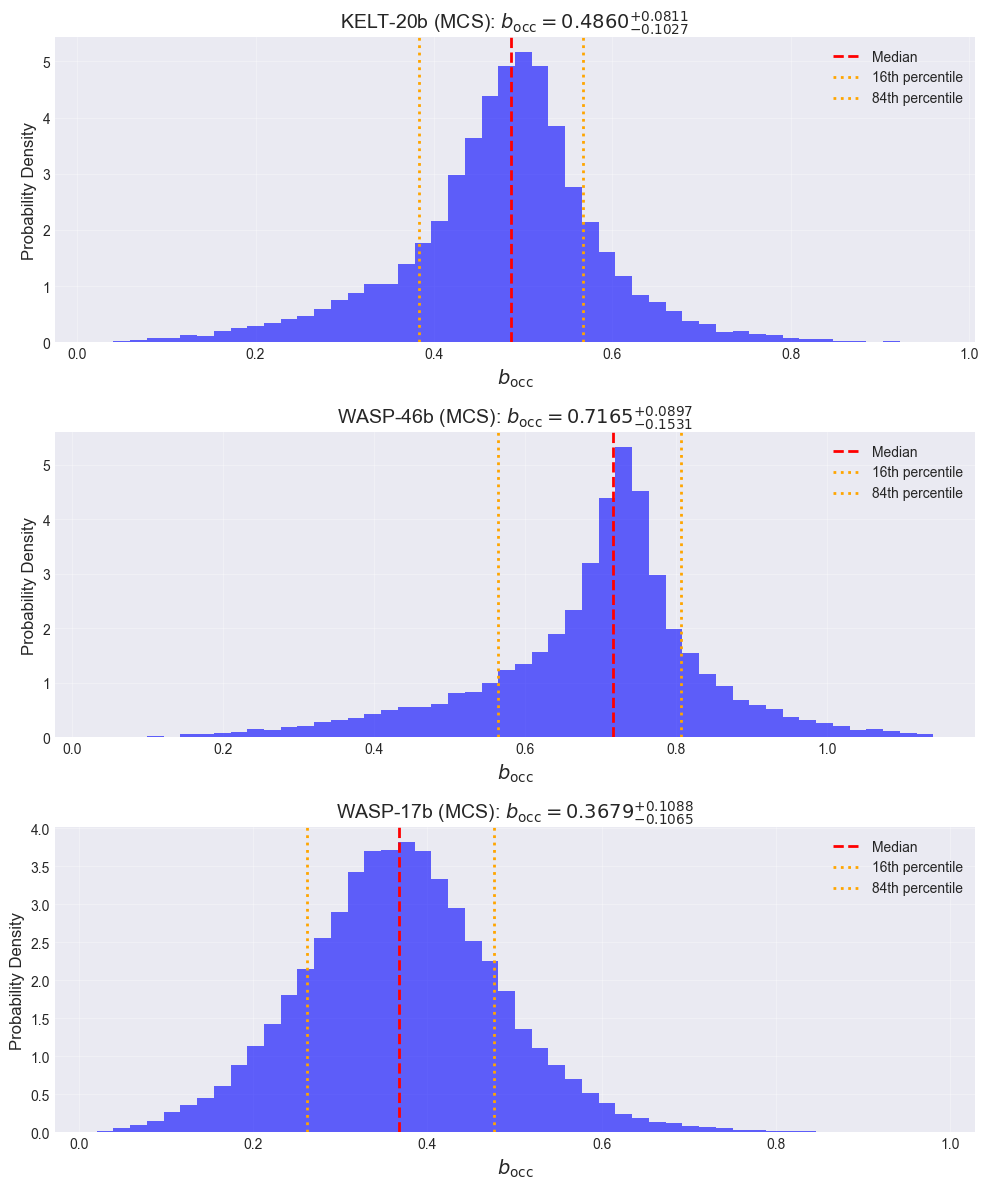

In [23]:
# Plot b_occ distributions for all analyzed systems
if len(mcmc_results) > 0:
    fig, axes = plt.subplots(len(mcmc_results), 1, figsize=(10, 4*len(mcmc_results)))
    
    if len(mcmc_results) == 1:
        axes = [axes]
    
    for i, result in enumerate(mcmc_results):
        ax = axes[i]
        
        # Histogram of b_occ
        ax.hist(result['b_occ_samples'], bins=50, density=True, alpha=0.6, color='blue')
        
        # Mark median and percentiles
        ax.axvline(result['b_occ_median'], color='red', linestyle='--', linewidth=2, label='Median')
        ax.axvline(result['b_occ_median'] - result['b_occ_err_lower'], color='orange', linestyle=':', linewidth=2, label='16th percentile')
        ax.axvline(result['b_occ_median'] + result['b_occ_err_upper'], color='orange', linestyle=':', linewidth=2, label='84th percentile')
        
        ax.set_xlabel(r'$b_{\rm occ}$', fontsize=14)
        ax.set_ylabel('Probability Density', fontsize=12)
        ax.set_title(f"{result['name']} ({result['dataset']}): $b_{{\\rm occ}} = {result['b_occ_median']:.4f}^{{+{result['b_occ_err_upper']:.4f}}}_{{-{result['b_occ_err_lower']:.4f}}}$", fontsize=14)
        ax.legend()
        ax.grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

## 9. Summary Table

Create a summary table of the MCMC results.

In [24]:
# Create summary DataFrame
if len(mcmc_results) > 0:
    summary_data = []
    
    for result in mcmc_results:
        summary_data.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'Eclipse Observed': result['eclipse_flag'],
            'b_occ (median)': f"{result['b_occ_median']:.4f}",
            'b_occ_16': f"{result['b_occ_16']:.4f}",
            'b_occ_84': f"{result['b_occ_84']:.4f}",
            'k (Rp/Rs)': f"{result['k']:.4f}",
            '1+k': f"{1+result['k']:.4f}",
            'Tier': result['tier'],
            'Tier Label': result['tier_label'],
            'Acceptance Fraction': f"{result['acceptance_fraction']:.3f}"
        })
    
    summary_df = pd.DataFrame(summary_data)
    display(summary_df)

,Planet,Dataset,Eclipse Observed,b_occ (median),b_occ_16,b_occ_84,k (Rp/Rs),1+k,Tier,Tier Label,Acceptance Fraction
0,KELT-20b,MCS,True,0.4860,0.3833,0.5671,0.1144,1.1144,1,Premium (non-grazing),0.499
1,WASP-46b,MCS,True,0.7165,0.5634,0.8062,0.1407,1.1407,1,Premium (non-grazing),0.495
2,WASP-17b,MCS,True,0.3679,0.2614,0.4767,0.1302,1.1302,1,Premium (non-grazing),0.498


## 10. Run Full Analysis (Optional)

Uncomment and run this cell to perform MCMC analysis on all systems. 
**Warning: This may take considerable time depending on the number of systems.**

In [ ]:
# Run MCMC on all systems - process MCS and TPC separately
import time

# Process MCS (Known planets) systems
print("="*70)
print("PROCESSING MCS (KNOWN PLANETS)")
print("="*70)
mcs_mcmc_results = []
start_time = time.time()

for i, system in enumerate(mcs_systems):
    print(f"\n[MCS {i+1}/{len(mcs_systems)}] Processing: {system['name']}")
    try:
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        mcs_mcmc_results.append(result)
        
        # Save intermediate results every 100 systems
        if (i + 1) % 100 == 0:
            temp_df = pd.DataFrame([{
                'Planet': r['name'],
                'Dataset': r['dataset'],
                'eclipse_observed': r['eclipse_flag'],
                'b_occ_median': r['b_occ_median'],
                'b_occ_16': r['b_occ_16'],
                'b_occ_84': r['b_occ_84'],
                'b_occ_std': r['b_occ_std'],
                'b_occ_err_lower': r['b_occ_err_lower'],
                'b_occ_err_upper': r['b_occ_err_upper'],
                'k_rp_rs': r['k'],
                'one_plus_k': 1 + r['k'],
                'tier': r['tier'],
                'tier_label': r['tier_label'],
                'acceptance_fraction': r['acceptance_fraction']
            } for r in mcs_mcmc_results])
            temp_df.to_csv('../results/mcs_eclipse_impact_parameter_mcmc_temp.csv', index=False)
            elapsed = time.time() - start_time
            print(f"\n>>> Checkpoint: {i+1} systems completed. Elapsed time: {elapsed/60:.1f} min")
    except Exception as e:
        print(f"ERROR processing {system['name']}: {e}")
        continue

mcs_elapsed = time.time() - start_time
print(f"\n{'='*70}")
print(f"MCS COMPLETE: {len(mcs_mcmc_results)}/{len(mcs_systems)} systems")
print(f"Time: {mcs_elapsed/60:.1f} min ({mcs_elapsed/len(mcs_mcmc_results):.1f} sec/system)")
print(f"{'='*70}\n")

# Process TPC (Candidate) systems
print("="*70)
print("PROCESSING TPC (TIER 1 CANDIDATES)")
print("="*70)
tpc_mcmc_results = []
start_time = time.time()

for i, system in enumerate(tpc_systems):
    print(f"\n[TPC {i+1}/{len(tpc_systems)}] Processing: {system['name']}")
    try:
        result = run_mcmc_for_system(system, nwalkers=32, nsteps=3000, burn_in=500)
        tpc_mcmc_results.append(result)
        
        # Save intermediate results every 100 systems
        if (i + 1) % 100 == 0:
            temp_df = pd.DataFrame([{
                'Planet': r['name'],
                'Dataset': r['dataset'],
                'eclipse_observed': r['eclipse_flag'],
                'b_occ_median': r['b_occ_median'],
                'b_occ_16': r['b_occ_16'],
                'b_occ_84': r['b_occ_84'],
                'b_occ_std': r['b_occ_std'],
                'b_occ_err_lower': r['b_occ_err_lower'],
                'b_occ_err_upper': r['b_occ_err_upper'],
                'k_rp_rs': r['k'],
                'one_plus_k': 1 + r['k'],
                'tier': r['tier'],
                'tier_label': r['tier_label'],
                'acceptance_fraction': r['acceptance_fraction']
            } for r in tpc_mcmc_results])
            temp_df.to_csv('../results/tpc_eclipse_impact_parameter_mcmc_temp.csv', index=False)
            elapsed = time.time() - start_time
            print(f"\n>>> Checkpoint: {i+1} systems completed. Elapsed time: {elapsed/60:.1f} min")
    except Exception as e:
        print(f"ERROR processing {system['name']}: {e}")
        continue

tpc_elapsed = time.time() - start_time
print(f"\n{'='*70}")
print(f"TPC COMPLETE: {len(tpc_mcmc_results)}/{len(tpc_systems)} systems")
print(f"Time: {tpc_elapsed/60:.1f} min ({tpc_elapsed/len(tpc_mcmc_results):.1f} sec/system)")
print(f"{'='*70}\n")

# Final summary
total_time = mcs_elapsed + tpc_elapsed
print(f"\n{'='*70}")
print(f"FULL ANALYSIS COMPLETE")
print(f"  MCS: {len(mcs_mcmc_results)} systems")
print(f"  TPC: {len(tpc_mcmc_results)} systems")
print(f"  Total: {len(mcs_mcmc_results) + len(tpc_mcmc_results)} systems")
print(f"  Total time: {total_time/3600:.2f} hours")
print(f"{'='*70}")

PROCESSING MCS (KNOWN PLANETS)

[MCS 1/808] Processing: K2-232b
Running MCMC for K2-232b...


100%|██████████| 3000/3000 [00:06<00:00, 431.63it/s]



  Eclipse observed: False
  b_occ = 0.1092 +0.0862 -0.0775
  i = 89.60 +0.28 -0.27 degrees
  k (Rp/Rs) = 0.0881, 1+k = 1.0881
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[MCS 2/808] Processing: Qatar-10b
Running MCMC for Qatar-10b...


100%|██████████| 3000/3000 [00:06<00:00, 455.83it/s]



  Eclipse observed: False
  b_occ = 0.3302 +0.1072 -0.1016
  i = 85.92 +0.94 -0.96 degrees
  k (Rp/Rs) = 0.1265, 1+k = 1.1265
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.492

[MCS 3/808] Processing: WASP-60b
Running MCMC for WASP-60b...


100%|██████████| 3000/3000 [00:06<00:00, 445.37it/s]



  Eclipse observed: False
  b_occ = 0.3338 +0.2875 -0.2651
  i = 87.92 +1.61 -1.56 degrees
  k (Rp/Rs) = 0.0775, 1+k = 1.0775
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.494

[MCS 4/808] Processing: WASP-20b
Running MCMC for WASP-20b...


100%|██████████| 3000/3000 [00:06<00:00, 452.98it/s]



  Eclipse observed: False
  b_occ = 0.7026 +0.1057 -0.1402
  i = 85.56 +0.22 -0.22 degrees
  k (Rp/Rs) = 0.1079, 1+k = 1.1079
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[MCS 5/808] Processing: HATS-52b
Running MCMC for HATS-52b...


100%|██████████| 3000/3000 [00:06<00:00, 450.78it/s]



  Eclipse observed: False
  b_occ = 0.4524 +0.1312 -0.1299
  i = 84.68 +1.09 -1.09 degrees
  k (Rp/Rs) = 0.1352, 1+k = 1.1352
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[MCS 6/808] Processing: TOI-1820b
Running MCMC for TOI-1820b...


100%|██████████| 3000/3000 [00:06<00:00, 461.45it/s]



  Eclipse observed: False
  b_occ = 0.8196 +0.1078 -0.1666
  i = 84.40 +0.29 -0.30 degrees
  k (Rp/Rs) = 0.0777, 1+k = 1.0777
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.482

[MCS 7/808] Processing: TOI-2202b
Running MCMC for TOI-2202b...


100%|██████████| 3000/3000 [00:06<00:00, 447.57it/s]



  Eclipse observed: False
  b_occ = 0.3024 +0.0938 -0.0874
  i = 89.30 +0.14 -0.15 degrees
  k (Rp/Rs) = 0.1265, 1+k = 1.1265
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[MCS 8/808] Processing: TOI-4087b
Running MCMC for TOI-4087b...


100%|██████████| 3000/3000 [00:06<00:00, 444.90it/s]



  Eclipse observed: False
  b_occ = 0.3149 +0.0761 -0.0816
  i = 87.83 +0.35 -0.36 degrees
  k (Rp/Rs) = 0.1076, 1+k = 1.1076
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[MCS 9/808] Processing: WASP-2b
Running MCMC for WASP-2b...


100%|██████████| 3000/3000 [00:06<00:00, 452.33it/s]



  Eclipse observed: False
  b_occ = 0.7319 +0.1039 -0.1657
  i = 84.48 +0.18 -0.17 degrees
  k (Rp/Rs) = 0.1283, 1+k = 1.1283
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.490

[MCS 10/808] Processing: K2-237b
Running MCMC for K2-237b...


100%|██████████| 3000/3000 [00:06<00:00, 449.45it/s]



  Eclipse observed: False
  b_occ = 0.1630 +0.1138 -0.0977
  i = 88.35 +0.94 -0.95 degrees
  k (Rp/Rs) = 0.1190, 1+k = 1.1190
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[MCS 11/808] Processing: KELT-20b
Running MCMC for KELT-20b...


100%|██████████| 3000/3000 [00:06<00:00, 453.78it/s]



  Eclipse observed: True
  b_occ = 0.4899 +0.0803 -0.1048
  i = 86.12 +0.27 -0.28 degrees
  k (Rp/Rs) = 0.1144, 1+k = 1.1144
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[MCS 12/808] Processing: WASP-107b
Running MCMC for WASP-107b...


100%|██████████| 3000/3000 [00:06<00:00, 456.16it/s]



  Eclipse observed: False
  b_occ = 0.0860 +0.0685 -0.0604
  i = 89.70 +0.20 -0.20 degrees
  k (Rp/Rs) = 0.1464, 1+k = 1.1464
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[MCS 13/808] Processing: TOI-2498b
Running MCMC for TOI-2498b...


100%|██████████| 3000/3000 [00:06<00:00, 447.07it/s]



  Eclipse observed: False
  b_occ = 0.3667 +0.2667 -0.2333
  i = 87.25 +1.67 -1.62 degrees
  k (Rp/Rs) = 0.0400, 1+k = 1.0400
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[MCS 14/808] Processing: WASP-197b
Running MCMC for WASP-197b...


100%|██████████| 3000/3000 [00:06<00:00, 434.11it/s]



  Eclipse observed: False
  b_occ = 0.4142 +0.0744 -0.0944
  i = 86.28 +0.33 -0.31 degrees
  k (Rp/Rs) = 0.0627, 1+k = 1.0627
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[MCS 15/808] Processing: WASP-187b
Running MCMC for WASP-187b...


100%|██████████| 3000/3000 [00:06<00:00, 457.68it/s]



  Eclipse observed: False
  b_occ = 0.7334 +0.1169 -0.1678
  i = 81.20 +0.50 -0.49 degrees
  k (Rp/Rs) = 0.0596, 1+k = 1.0596
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.489

[MCS 16/808] Processing: Kepler-1517b
Running MCMC for Kepler-1517b...


100%|██████████| 3000/3000 [00:06<00:00, 461.64it/s]



  Eclipse observed: False
  b_occ = 0.6408 +0.2635 -0.3123
  i = 83.91 +0.50 -0.50 degrees
  k (Rp/Rs) = 0.0505, 1+k = 1.0505
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.462

[MCS 17/808] Processing: WASP-170b
Running MCMC for WASP-170b...


100%|██████████| 3000/3000 [00:06<00:00, 444.07it/s]



  Eclipse observed: False
  b_occ = 0.6698 +0.1048 -0.1596
  i = 84.87 +0.28 -0.27 degrees
  k (Rp/Rs) = 0.1175, 1+k = 1.1175
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.496

[MCS 18/808] Processing: WASP-61b
Running MCMC for WASP-61b...


100%|██████████| 3000/3000 [00:06<00:00, 446.42it/s]



  Eclipse observed: False
  b_occ = 0.0968 +0.0796 -0.0734
  i = 89.26 +0.56 -0.54 degrees
  k (Rp/Rs) = 0.0895, 1+k = 1.0895
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[MCS 19/808] Processing: WASP-37b
Running MCMC for WASP-37b...


100%|██████████| 3000/3000 [00:06<00:00, 450.93it/s]



  Eclipse observed: False
  b_occ = 0.1764 +0.1446 -0.1257
  i = 88.83 +0.81 -0.81 degrees
  k (Rp/Rs) = 0.1188, 1+k = 1.1188
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[MCS 20/808] Processing: WASP-46b
Running MCMC for WASP-46b...


100%|██████████| 3000/3000 [00:06<00:00, 445.90it/s]



  Eclipse observed: True
  b_occ = 0.7204 +0.1009 -0.1516
  i = 82.80 +0.17 -0.17 degrees
  k (Rp/Rs) = 0.1407, 1+k = 1.1407
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[MCS 21/808] Processing: HD191939b
Running MCMC for HD191939b...


100%|██████████| 3000/3000 [00:06<00:00, 442.72it/s]



  Eclipse observed: False
  b_occ = 0.5939 +0.0946 -0.1186
  i = 88.10 +0.12 -0.12 degrees
  k (Rp/Rs) = 0.0332, 1+k = 1.0332
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.498

[MCS 22/808] Processing: TOI-4914b
Running MCMC for TOI-4914b...


100%|██████████| 3000/3000 [00:07<00:00, 394.83it/s]



  Eclipse observed: False
  b_occ = 0.9874 +0.1248 -0.2653
  i = 86.38 +0.23 -0.29 degrees
  k (Rp/Rs) = 0.1180, 1+k = 1.1180
  Tier: 2 - Good (includes grazing)
  Acceptance fraction: 0.310

[MCS 23/808] Processing: TOI-1898b
Running MCMC for TOI-1898b...


100%|██████████| 3000/3000 [00:07<00:00, 426.27it/s]



  Eclipse observed: False
  b_occ = 0.8438 +0.1491 -0.2490
  i = 88.33 +0.37 -0.46 degrees
  k (Rp/Rs) = 0.0534, 1+k = 1.0534
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.440

[MCS 24/808] Processing: WASP-17b
Running MCMC for WASP-17b...


100%|██████████| 3000/3000 [00:07<00:00, 423.29it/s]



  Eclipse observed: True
  b_occ = 0.3734 +0.1055 -0.1085
  i = 86.83 +0.60 -0.62 degrees
  k (Rp/Rs) = 0.1302, 1+k = 1.1302
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[MCS 25/808] Processing: TOI-5108b
Running MCMC for TOI-5108b...


100%|██████████| 3000/3000 [00:06<00:00, 441.51it/s]



  Eclipse observed: False
  b_occ = 0.8375 +0.0958 -0.1810
  i = 85.91 +0.14 -0.14 degrees
  k (Rp/Rs) = 0.0472, 1+k = 1.0472
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.476

[MCS 26/808] Processing: WASP-91b
Running MCMC for WASP-91b...


100%|██████████| 3000/3000 [00:06<00:00, 448.69it/s]



  Eclipse observed: False
  b_occ = 0.4832 +0.1101 -0.1142
  i = 86.81 +0.39 -0.40 degrees
  k (Rp/Rs) = 0.1231, 1+k = 1.1231
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.492

[MCS 27/808] Processing: WASP-121b
Running MCMC for WASP-121b...


100%|██████████| 3000/3000 [00:06<00:00, 444.89it/s]



  Eclipse observed: True
  b_occ = 0.1468 +0.0518 -0.0463
  i = 87.61 +0.58 -0.61 degrees
  k (Rp/Rs) = 0.1245, 1+k = 1.1245
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.497

[MCS 28/808] Processing: WASP-172b
Running MCMC for WASP-172b...


100%|██████████| 3000/3000 [00:06<00:00, 428.79it/s]



  Eclipse observed: False
  b_occ = 0.4297 +0.1850 -0.1694
  i = 86.71 +1.09 -1.09 degrees
  k (Rp/Rs) = 0.0845, 1+k = 1.0845
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.500

[MCS 29/808] Processing: HATS-51b
Running MCMC for HATS-51b...


100%|██████████| 3000/3000 [00:06<00:00, 432.60it/s]



  Eclipse observed: False
  b_occ = 0.3288 +0.2103 -0.1928
  i = 87.05 +1.63 -1.59 degrees
  k (Rp/Rs) = 0.1010, 1+k = 1.1010
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.495

[MCS 30/808] Processing: WASP-173Ab
Running MCMC for WASP-173Ab...


100%|██████████| 3000/3000 [00:06<00:00, 431.69it/s]



  Eclipse observed: False
  b_occ = 0.2792 +0.2080 -0.1845
  i = 86.41 +2.33 -2.28 degrees
  k (Rp/Rs) = 0.1203, 1+k = 1.1203
  Tier: 1 - Premium (non-grazing)
  Acceptance fraction: 0.499

[MCS 31/808] Processing: Kepler-138b
Running MCMC for Kepler-138b...


 39%|███▉      | 1170/3000 [00:02<00:03, 459.49it/s]Traceback (most recent call last):
  File "/Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/.venv/lib/python3.9/site-packages/emcee/ensemble.py", line 640, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_14196/3914048073.py", line 136, in log_probability
    lp = log_prior(theta, system)
  File "/var/folders/1f/bw5yv25n23ndx4ymmhx70qv00000gn/T/ipykernel_14196/3914048073.py", line 73, in log_prior
    log_prob += norm.logpdf(
  File "/Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py", line 2037, in logpdf
    goodargs = argsreduce(cond, *((x,)+args+(scale,)))
  File "/Users/zoutongshen/Library/CloudStorage/Dropbox/Academics/03_Research/Ariel/.venv/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py", line 606, in argsreduce

emcee: Exception while calling your likelihood function:
  params: [2.92656623e+01 2.38582115e-02 4.42371131e-01 1.74037240e+02]
  args: ({'name': 'Kepler-138b', 'a_over_rs': 30.3, 'a_over_rs_err': 0.8, 'b_tra': 0.7, 'b_tra_err': 0.03, 'inclination': 88.67, 'inclination_err': 0.08, 'cos_i': 0.023210794445087096, 'cos_i_err': 0.0013958872387692563, 'eccentricity': 0.02, 'eccentricity_err': 0.009, 'periastron': 40.0, 'periastron_err': 20.0, 'rp_rs': 0.010967193, 'eclipse_flag': False, 'dataset': 'MCS'},)
  kwargs: {}
  exception:


KeyboardInterrupt: 

## 11. Save Results

In [ ]:
# Save the MCMC results to CSV - separate files for MCS and TPC

# For test runs (mcmc_results from small test)
if len(mcmc_results) > 0:
    output_data = []
    
    for result in mcmc_results:
        output_data.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'eclipse_observed': result['eclipse_flag'],
            'b_occ_median': result['b_occ_median'],
            'b_occ_16': result['b_occ_16'],
            'b_occ_84': result['b_occ_84'],
            'b_occ_std': result['b_occ_std'],
            'b_occ_err_lower': result['b_occ_err_lower'],
            'b_occ_err_upper': result['b_occ_err_upper'],
            'k_rp_rs': result['k'],
            'one_plus_k': 1 + result['k'],
            'tier': result['tier'],
            'tier_label': result['tier_label'],
            'acceptance_fraction': result['acceptance_fraction']
        })
    
    output_df = pd.DataFrame(output_data)
    output_file = '../results/eclipse_impact_parameter_mcmc_test.csv'
    output_df.to_csv(output_file, index=False)
    print(f"Test results saved to {output_file}")

# For full batch runs (mcs_mcmc_results and tpc_mcmc_results)
if 'mcs_mcmc_results' in locals() and len(mcs_mcmc_results) > 0:
    mcs_output_data = []
    for result in mcs_mcmc_results:
        mcs_output_data.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'eclipse_observed': result['eclipse_flag'],
            'b_occ_median': result['b_occ_median'],
            'b_occ_16': result['b_occ_16'],
            'b_occ_84': result['b_occ_84'],
            'b_occ_std': result['b_occ_std'],
            'b_occ_err_lower': result['b_occ_err_lower'],
            'b_occ_err_upper': result['b_occ_err_upper'],
            'k_rp_rs': result['k'],
            'one_plus_k': 1 + result['k'],
            'tier': result['tier'],
            'tier_label': result['tier_label'],
            'acceptance_fraction': result['acceptance_fraction']
        })
    mcs_df_out = pd.DataFrame(mcs_output_data)
    mcs_file_out = '../results/mcs_eclipse_impact_parameter_mcmc.csv'
    mcs_df_out.to_csv(mcs_file_out, index=False)
    print(f"MCS results saved to {mcs_file_out} ({len(mcs_mcmc_results)} systems)")

if 'tpc_mcmc_results' in locals() and len(tpc_mcmc_results) > 0:
    tpc_output_data = []
    for result in tpc_mcmc_results:
        tpc_output_data.append({
            'Planet': result['name'],
            'Dataset': result['dataset'],
            'eclipse_observed': result['eclipse_flag'],
            'b_occ_median': result['b_occ_median'],
            'b_occ_16': result['b_occ_16'],
            'b_occ_84': result['b_occ_84'],
            'b_occ_std': result['b_occ_std'],
            'b_occ_err_lower': result['b_occ_err_lower'],
            'b_occ_err_upper': result['b_occ_err_upper'],
            'k_rp_rs': result['k'],
            'one_plus_k': 1 + result['k'],
            'tier': result['tier'],
            'tier_label': result['tier_label'],
            'acceptance_fraction': result['acceptance_fraction']
        })
    tpc_df_out = pd.DataFrame(tpc_output_data)
    tpc_file_out = '../results/tpc_eclipse_impact_parameter_mcmc.csv'
    tpc_df_out.to_csv(tpc_file_out, index=False)
    print(f"TPC results saved to {tpc_file_out} ({len(tpc_mcmc_results)} systems)")

Results saved to ../results/eclipse_impact_parameter_mcmc.csv


## 12. Summary Statistics and Plots (Optional)

Run this cell after batch processing to generate summary statistics and distribution plots.

In [ ]:
# Generate summary statistics after batch processing
# This cell is optional - run only after full batch analysis completes

if 'mcs_mcmc_results' in locals() and len(mcs_mcmc_results) > 0:
    print("="*70)
    print("MCS (KNOWN PLANETS) SUMMARY")
    print("="*70)
    
    mcs_tiers = [r['tier'] for r in mcs_mcmc_results]
    mcs_with_eclipse = [r for r in mcs_mcmc_results if r['eclipse_flag'] == True]
    mcs_without_eclipse = [r for r in mcs_mcmc_results if r['eclipse_flag'] == False]
    
    print(f"\nTotal systems analyzed: {len(mcs_mcmc_results)}")
    print(f"  With observed eclipses: {len(mcs_with_eclipse)}")
    print(f"  Without observed eclipses: {len(mcs_without_eclipse)}")
    
    print(f"\nTier Distribution:")
    for tier in [1, 2, 3, 4]:
        count = mcs_tiers.count(tier)
        pct = 100 * count / len(mcs_tiers)
        print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Tier distribution for systems WITH observed eclipses
    if len(mcs_with_eclipse) > 0:
        print(f"\nTier Distribution (Eclipse Observed):")
        eclipse_tiers = [r['tier'] for r in mcs_with_eclipse]
        for tier in [1, 2, 3, 4]:
            count = eclipse_tiers.count(tier)
            pct = 100 * count / len(eclipse_tiers) if len(eclipse_tiers) > 0 else 0
            print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Acceptance fraction statistics
    accept_fracs = [r['acceptance_fraction'] for r in mcs_mcmc_results]
    print(f"\nAcceptance Fraction: {np.mean(accept_fracs):.3f} ± {np.std(accept_fracs):.3f}")
    print(f"  Range: [{np.min(accept_fracs):.3f}, {np.max(accept_fracs):.3f}]")

if 'tpc_mcmc_results' in locals() and len(tpc_mcmc_results) > 0:
    print("\n" + "="*70)
    print("TPC (TIER 1 CANDIDATES) SUMMARY")
    print("="*70)
    
    tpc_tiers = [r['tier'] for r in tpc_mcmc_results]
    
    print(f"\nTotal systems analyzed: {len(tpc_mcmc_results)}")
    
    print(f"\nTier Distribution:")
    for tier in [1, 2, 3, 4]:
        count = tpc_tiers.count(tier)
        pct = 100 * count / len(tpc_tiers)
        print(f"  Tier {tier}: {count:4d} ({pct:5.1f}%)")
    
    # Acceptance fraction statistics
    accept_fracs = [r['acceptance_fraction'] for r in tpc_mcmc_results]
    print(f"\nAcceptance Fraction: {np.mean(accept_fracs):.3f} ± {np.std(accept_fracs):.3f}")
    print(f"  Range: [{np.min(accept_fracs):.3f}, {np.max(accept_fracs):.3f}]")

In [ ]:
# Optional: Create summary distribution plots
# Run this after batch processing completes

fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: b_occ distribution by tier (MCS)
if 'mcs_mcmc_results' in locals() and len(mcs_mcmc_results) > 0:
    ax = axes[0, 0]
    for tier in [1, 2, 3, 4]:
        tier_results = [r for r in mcs_mcmc_results if r['tier'] == tier]
        if len(tier_results) > 0:
            b_occs = [r['b_occ_median'] for r in tier_results]
            ax.hist(b_occs, bins=30, alpha=0.5, label=f'Tier {tier} (n={len(tier_results)})')
    ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='b_occ = 1')
    ax.set_xlabel('b_occ (median)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('MCS: Eclipse Impact Parameter Distribution by Tier', fontsize=13)
    ax.legend()
    ax.grid(alpha=0.3)

# Plot 2: Tier distribution (MCS)
if 'mcs_mcmc_results' in locals() and len(mcs_mcmc_results) > 0:
    ax = axes[0, 1]
    mcs_tiers = [r['tier'] for r in mcs_mcmc_results]
    tier_counts = [mcs_tiers.count(t) for t in [1, 2, 3, 4]]
    tier_labels = [f'Tier {t}' for t in [1, 2, 3, 4]]
    colors = ['green', 'blue', 'orange', 'red']
    ax.bar(tier_labels, tier_counts, color=colors, alpha=0.7)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('MCS: Tier Distribution', fontsize=13)
    ax.grid(axis='y', alpha=0.3)
    for i, count in enumerate(tier_counts):
        pct = 100 * count / sum(tier_counts)
        ax.text(i, count + max(tier_counts)*0.02, f'{count}\\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=10)

# Plot 3: b_occ distribution by tier (TPC)
if 'tpc_mcmc_results' in locals() and len(tpc_mcmc_results) > 0:
    ax = axes[1, 0]
    for tier in [1, 2, 3, 4]:
        tier_results = [r for r in tpc_mcmc_results if r['tier'] == tier]
        if len(tier_results) > 0:
            b_occs = [r['b_occ_median'] for r in tier_results]
            ax.hist(b_occs, bins=30, alpha=0.5, label=f'Tier {tier} (n={len(tier_results)})')
    ax.axvline(1.0, color='red', linestyle='--', linewidth=2, label='b_occ = 1')
    ax.set_xlabel('b_occ (median)', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('TPC: Eclipse Impact Parameter Distribution by Tier', fontsize=13)
    ax.legend()
    ax.grid(alpha=0.3)

# Plot 4: Tier distribution (TPC)
if 'tpc_mcmc_results' in locals() and len(tpc_mcmc_results) > 0:
    ax = axes[1, 1]
    tpc_tiers = [r['tier'] for r in tpc_mcmc_results]
    tier_counts = [tpc_tiers.count(t) for t in [1, 2, 3, 4]]
    tier_labels = [f'Tier {t}' for t in [1, 2, 3, 4]]
    colors = ['green', 'blue', 'orange', 'red']
    ax.bar(tier_labels, tier_counts, color=colors, alpha=0.7)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('TPC: Tier Distribution', fontsize=13)
    ax.grid(axis='y', alpha=0.3)
    for i, count in enumerate(tier_counts):
        pct = 100 * count / sum(tier_counts)
        ax.text(i, count + max(tier_counts)*0.02, f'{count}\\n({pct:.1f}%)', 
                ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.savefig('../results/eclipse_impact_parameter_summary.png', dpi=150, bbox_inches='tight')
print("Summary plot saved to ../results/eclipse_impact_parameter_summary.png")
plt.show()

## Summary

This notebook performs MCMC analysis on the eclipse impact parameter $b_{\text{occ}}$ for exoplanet systems in the Ariel MCS and TPC catalogs. The analysis:

1. Loads the updated 2025-07-18 data files
2. Identifies the correct column names for required parameters
3. Implements the eclipse impact parameter equation from Winn (2010)
4. Uses **informative priors** based on transit observations:
   - Normal prior on $a/R_\star$ (from transit + stellar modeling)
   - **Normal prior on $\cos i$** (derived from transit inclination; more natural for geometry)
   - **Beta prior on eccentricity** (Kipping 2013: α=0.867, β=3.03 for short-period planets)
   - Uniform prior on $\omega$ (argument of periastron)
5. Implements **hard constraint**: occultation must exist ($|b_{\rm occ}| \leq 1 + k$)
6. Uses scipy.stats logpdf for numerically robust prior calculations
7. Visualizes the posterior distributions
8. Assigns tier classification based on eclipse detectability
9. Saves the results for further analysis

The key parameters sampled in the MCMC are:
- Scaled semi-major axis ($a/R_\star$)
- **Cosine of inclination ($\cos i$)** - sampled directly instead of transit impact parameter
- Eccentricity ($e$)
- Argument of periastron ($\omega$)

The inclination ($i$) and eclipse impact parameter ($b_{\rm occ}$) are derived quantities computed from the sampled parameters.